# Part III : Visualizing what ConvNets learn

We will introduce a visualization technique that is useful for understanding which parts of a given image led a ConvNet to its final classification decision. This is helpful for debugging the decision process of a ConvNet, particularly in the case of a classification mistake. It also allows you to locate specific objects in an image.  

This general category of techniques is called a _class activation map_ (CAM) visualization, and it consists of producing heatmaps of class activation over input images. A class activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to the class under consideration. For instance, given an image fed into a dogs-versus-cats ConvNet, CAM visualization allows you to generate a heatmap for the class "cat", indicating how cat-like different parts of the image are, and also a heatmap for the class "dog", indicating how dog-like parts of the image are. 

The specific implementation we will use is the one described in _"Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization."_ It's very simple: it consists of taking the output activations maps of a convolutional layer, given an input image, and weighing every activation map in that output volume by the gradient of the class with respect to the activation map. Intuitively, one way to understand this trick is that you are weighting a spatial map of "how intensely the input image activates different activation maps" by " how important each activation map is with regard to the class", resulting in a spatial map of "how intensely the input image activates the class."

We will demononstrate this technique using the pretrained VGG16 network again.


### Loading the VGG16 network with pretrained weights

Note that we include the densely connected classifier on top; in  
previous cases, we discarded it.

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 62s 0us/step


Consider the image of two African elephants shown below, possibly a mother and her calf, strolling on the savanna. Let us convert this image into something the VGG16 model can read: the model was trained on images of size 224x224, preprocessed according to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize it to 224x224, convert it to a Numpy `float32` tensor, and apply theses preprocessing rules.


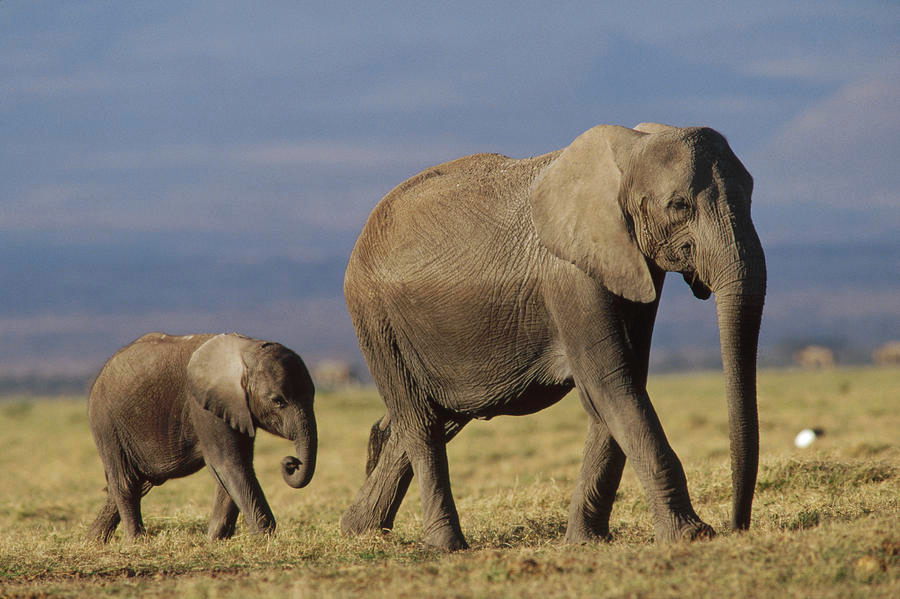

In [18]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import cv2 # if not installed, execute : !pip install opencv-python
# Local path to the target image
#img_path = './african-elephant.jpg'
img_path = './mask6.png'
image_orig = cv2.imread(img_path)
print(image_orig.shape)

# Python Imaging Library (PIL) image of size 224x224
img = image.load_img(img_path, target_size=(224,224))

# float32 Numpy array of shape (224,224,3)
x = image.img_to_array(img)

# Adds a dimension to transform the array into a batch of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)
print(x.shape)

# Preprocess the batch (this does activation-map-wise color normalization)
x = preprocess_input(x)

(405, 600, 3)
(1, 224, 224, 3)


We can now run the pretrained network on the image and decode its prediction vector back to a human-readable format:

In [19]:
preds = model.predict(x)
print('Predicted', decode_predictions(preds, top=3)[0])

Predicted [('n03630383', 'lab_coat', 0.27947173), ('n03868863', 'oxygen_mask', 0.24717873), ('n03814639', 'neck_brace', 0.061226908)]


The top three classes predicted for this image are as follows:

- African elephant (with 55% probability)
- Tusker (with 23% probability)
- Indian elephant (with  18% probability)

The network has recognized the image as containing an undetermined quantity of African elephants. The entry in the 
prediction vector that was maximally activated is the one corresponding to the "African elephant" class, index 386:

In [20]:
np.argmax(preds[0])

617

To visualize which parts of the image are the most African elephant-like, let's set up the Grad-CAM process. 

### Setting up the Grad-CAM algorithm

In [21]:
# import the necessary packages

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)


# initialize the model to be VGG16
Model = VGG16

# load the pre-trained CNN from disk
print("[INFO] loading model...")
model = Model(weights="imagenet")



# import the necessary packages
from tensorflow.keras.models import Model

import numpy as np
# !pip install opencv-python-headless
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")  

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1) 
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        #(w, h) = (image.shape[2], image.shape[1])
        heatmap = cam.numpy()
        #heatmap = cv2.resize(cam_num, (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

 

index_true_class = np.argmax(preds[0])
print(index_true_class)
cam = GradCAM(model, index_true_class)
heatmap = cam.compute_heatmap(x)
print(heatmap.shape)

[INFO] loading model...
617
(7, 7)


The result is shown below:

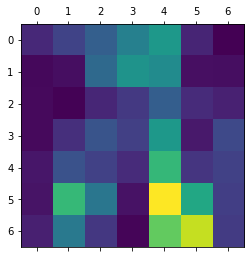

In [22]:
import matplotlib.pyplot as plt
plt.matshow(heatmap)

### Superimposing the heatmap with the original picture

Finally, we will use OpenCV to generate an image that superimposes the original image on the heatmap we just obtained.

In [23]:
import cv2

# uses cv2 to load the original image
img = cv2.imread(img_path) 

# resizes the heatmap to be the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# applies the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# saves the image to disk
cv2.imwrite('./mask_cam.jpg', superimposed_img)

True

![title](./elephant_cam.jpg)

The visualization technique answers two important questions:

- Why did the network think this image contained an African elephant?

- Where is the African elephant located in the picture?

In particular, it's interesting to note that the elephant calf is strongly activated.

# Part IV : Object Detection with Mask R-CNN

### Please run this section on Colab !

Object detection is a task in computer vision that involves identifying the presence, location, and type of one or more objects in a given photograph.

It is a challenging problem that involves building upon methods for object recognition (e.g. where are they), object localization (e.g. what are their extent), and object classification (e.g. what are they).

In recent years, deep learning techniques have achieved state-of-the-art results for object detection, such as on standard benchmark datasets and in computer vision competitions. Most notably is the R-CNN, or Region-Based Convolutional Neural Networks, and the most recent technique called Mask R-CNN that is capable of achieving state-of-the-art results on a range of object detection tasks.

In this section, we will discover how to use the __Mask R-CNN__ model to detect objects in new photographs.

After completing this tutorial, you will know:

- The region-based Convolutional Neural Network family of models for object detection and the most recent variation called Mask R-CNN.

- The best-of-breed open source library implementation of the Mask R-CNN for the Keras deep learning library.
    
- How to use a pre-trained Mask R-CNN to perform object localization and detection on new photographs.



## Mask R-CNN for Object Detection

Object detection is a computer vision task that involves both localizing one or more objects within an image and classifying each object in the image.

It is a challenging computer vision task that requires both successful object localization in order to locate and draw a bounding box around each object in an image, and object classification to predict the correct class of object that was localized.

An extension of object detection involves marking the specific pixels in the image that belong to each detected object instead of using coarse bounding boxes during object localization. This harder version of the problem is generally referred to as object segmentation or semantic segmentation.

The __Region-Based__ Convolutional Neural Network, or R-CNN, is a family of convolutional neural network models designed for object detection, developed by Ross Girshick, et al.

There are perhaps four main variations of the approach, resulting in the current pinnacle called Mask R-CNN. The salient aspects of each variation can be summarized as follows:

- __R-CNN__: Bounding boxes are proposed by the “selective search” algorithm, each of which is stretched and features are extracted via a deep convolutional neural network, such as AlexNet, before a final set of object classifications are made with linear SVMs.

- __Fast R-CNN__: Simplified design with a single model, bounding boxes are still specified as input, but a region-of-interest pooling layer is used after the deep CNN to consolidate regions and the model predicts both class labels and regions of interest directly.
    
- __Faster R-CNN__: Addition of a Region Proposal Network that interprets features extracted from the deep CNN and learns to propose regions-of-interest directly.
    
- __Mask R-CNN__: Extension of Faster R-CNN that adds an output model for predicting a mask for each detected object.

The Mask R-CNN model introduced in the 2018 paper titled [Mask R-CNN](https://arxiv.org/abs/1703.06870) is the most recent variation of the family models and supports both object detection and object segmentation. The paper provides a nice summary of the model linage to that point:



### Matterport Mask R-CNN Project

Mask R-CNN is a sophisticated model to implement, especially as compared to a simple or even state-of-the-art deep convolutional neural network model.

Source code is available for each version of the R-CNN model, provided in separate GitHub repositories with prototype models based on the Caffe deep learning framework. For example:

- R-CNN: [Regions with Convolutional Neural Network Features, GitHub](https://github.com/rbgirshick/rcnn)

- Fast R-CNN, [GitHub](https://github.com/rbgirshick/fast-rcnn)

- Faster R-CNN Python Code, [GitHub](https://github.com/rbgirshick/py-faster-rcnn)

- Detectron, Facebook AI, [GitHub](https://github.com/facebookresearch/Detectron)

Instead of developing an implementation of the R-CNN or Mask R-CNN model from scratch, we can use a reliable third-party implementation built on top of the Keras deep learning framework.

The best of breed third-party implementations of Mask R-CNN is the [Mask R-CNN](https://github.com/matterport/Mask_RCNN) Project developed by Matterport. The project is open source released under a permissive license (i.e. MIT license) and the code has been widely used on a variety of projects and Kaggle competitions.

Nevertheless, it is an open source project, subject to the whims of the project developers. As such, I have a fork of the project available, just in case there are major changes to the API in the future.

The project is light on API documentation, although it does provide a number of examples in the form of Python Notebooks that you can use to understand how to use the library by example. Two notebooks that may be helpful to review are:

- Mask R-CNN Demo, [Notebook](https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb)

- Mask R-CNN – Inspect Trained Model, [Notebook](https://github.com/matterport/Mask_RCNN/blob/master/samples/coco/inspect_model.ipynb)

There are perhaps three main use cases for using the Mask R-CNN model with the Matterport library; they are:

- __Object Detection Application__: Use a pre-trained model for object detection on new images.

- __New Model via Transfer Learning__: Use a pre-trained model as a starting point in developing a model for a new object detection dataset.
    
- __New Model from Scratch__: Develop a new model from scratch for an object detection dataset.

In order to get familiar with the model and the library, we will look at the first example in the next section.

#### Object Detection With Mask R-CNN

In this section, we will use the Matterport Mask R-CNN library to perform object detection on arbitrary photographs.

Much like using a pre-trained deep CNN for image classification, e.g. such as VGG-16 trained on an ImageNet dataset, we can use a pre-trained Mask R-CNN model to detect objects in new photographs. In this case, we will use a Mask R-CNN trained on the [MS COCO object detection problem](http://cocodataset.org/#home).

#### Mask R-CNN Installation

The first step is to install the library.

At the time of writing, there is no distributed version of the library, so we have to install it manually. The good news is that this is very easy.

Installation involves cloning the GitHub repository and running the installation script on your workstation. If you are having trouble, see the [installation instructions](https://github.com/matterport/Mask_RCNN#installation) buried in the library’s readme file.

#### Step 0. Open Colab and Upload this Notebook

#### Step 1. Clone the Mask R-CNN GitHub Repository

This is as simple as running the following command from your command line:

In [24]:
#!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
Checking out files:  96% (73/76)
Checking out files:  97% (74/76)
Checking out files:  98% (75/76)
Checking out files: 100% (76/76)
Checking out files: 100% (76/76), done.


This will create a new local directory with the name Mask_RCNN that looks as follows:

Mask_RCNN
├── assets
├── build
│   ├── bdist.macosx-10.13-x86_64
│   └── lib
│       └── mrcnn
├── dist
├── images
├── mask_rcnn.egg-info
├── mrcnn
└── samples
    ├── balloon
    ├── coco
    ├── nucleus
    └── shapes

#### Step 2. Install the Mask R-CNN Library

The library can be installed directly via pip.

Change directory into the _Mask_RCNN_ directory and run the installation script.

From the command line, type the following:

In [7]:
import os
os.chdir('C:/Users/fabiantrottmann/OneDrive/Master_DS/4. Semester/DeepLearningInVision/Block 5 - Object Detection and Segmentation/Mask_RCNN')
!pip3 install -r requirements.txt 
!python setup.py install

zip_safe flag not set; analyzing archive contents...


running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info\PKG-INFO
writing dependency_links to mask_rcnn.egg-info\dependency_links.txt
writing top-level names to mask_rcnn.egg-info\top_level.txt
writing manifest file 'mask_rcnn.egg-info\SOURCES.txt'
reading manifest file 'mask_rcnn.egg-info\SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
creating build
creating build\lib
creating build\lib\mrcnn
copying mrcnn\config.py -> build\lib\mrcnn
copying mrcnn\model.py -> build\lib\mrcnn
copying mrcnn\parallel_model.py -> build\lib\mrcnn
copying mrcnn\utils.py -> build\lib\mrcnn
copying mrcnn\visualize.py -> build\lib\mrcnn
copying mrcnn\__init__.py -> build\lib\mrcnn
creating build\bdist.win-amd64
creating build\bdist.win-amd64\egg
creating build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\con

The library will then install directly and you will see a lot of successful installation messages ending with the following:

...
Finished processing dependencies for mask-rcnn==2.1

#### Step 3: Confirm the Library Was Installed

It is always a good idea to confirm that the library was installed correctly.

You can confirm that the library was installed correctly by querying it via the pip command; for example:

In [8]:
!pip3 show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: c:\users\fabiantrottmann\anaconda3\envs\tensorflow\lib\site-packages\mask_rcnn-2.1-py3.7.egg
Requires: 
Required-by: 


### Example of Object Localization

We are going to use a pre-trained Mask R-CNN model to detect objects on a new photograph.

#### Step 1. Download Model Weights

First, download the weights for the pre-trained model, specifically a Mask R-CNN trained on the MS Coco dataset.

The weights are available from the project GitHub project and the file is about 250 megabytes. Download the model weights to a file with the name ‘mask_rcnn_coco.h5‘ in your current working directory.

[Download Weights (mask_rcnn_coco.h5)](https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5) (246 megabytes)

#### Step 2. Download Sample Photograph

We also need a photograph in which to detect objects.

Download from Ilias the photograph to your current working directory with the filename ‘african-elephant.jpg‘


african-elephant.jpg![grafik.png](attachment:grafik.png)

#### Step 3. Load Model and Make Prediction

First, the model must be defined via an instance MaskRCNN class.

This class requires a configuration object as a parameter. The configuration object defines how the model might be used during training or inference.

In this case, the configuration will only specify the number of images per batch, which will be one, and the number of classes to predict.

You can see the full extent of the configuration object and the properties that you can override in the [config.py](https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/config.py) file.

In [17]:
#%tensorflow_version 2.x
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
# define the test configuration
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 80

We can now define the MaskRCNN instance.

We will define the model as type “inference” indicating that we are interested in making predictions and not training. We must also specify a directory where any log messages could be written, which in this case will be the current working directory.

In [22]:
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())

AttributeError: module 'tensorflow' has no attribute 'log'

The next step is to load the weights that we downloaded. You should save it on google drive and then load it.

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# load coco model weights
rcnn.load_weights('/content/drive/My Drive/mask_rcnn_coco.h5', by_name=True)

NameError: name 'rcnn' is not defined

Now we can make a prediction for our image. First, we can load the image and convert it to a NumPy array.

In [ ]:
from tensorflow.keras.preprocessing import image
# load photograph
img = image.load_img('/content/drive/My Drive/african-elephant.jpg')
img = image.img_to_array(img)

We can then make a prediction with the model. Instead of calling `predict()` as we would on a normal Keras model, will call the `detect()` function and pass it the single image.

In [ ]:
# make prediction
results = rcnn.detect([img], verbose=0)

The result contains a dictionary for each image that we passed into the `detect()` function, in this case, a list of a single dictionary for the one image.

The dictionary has keys for the bounding boxes, masks, and so on, and each key points to a list for multiple possible objects detected in the image.

The keys of the dictionary of note are as follows:

- __‘rois‘__: The bound boxes or regions-of-interest (ROI) for detected objects.
- __‘masks‘__: The masks for the detected objects.
- __‘class_ids‘__: The class integers for the detected objects.
- __‘scores‘__: The probability or confidence for each predicted class.

We can draw each box detected in the image by first getting the dictionary for the first image (e.g. results[0]), and then retrieving the list of bounding boxes (e.g. [‘rois’]).

In [ ]:
boxes = results[0]['rois']

Each bounding box is defined in terms of the bottom left and top right coordinates of the bounding box in the image

In [ ]:
y1, x1, y2, x2 = boxes[0]

We can use these coordinates to create a `Rectangle()` from the matplotlib API and draw each rectangle over the top of our image.

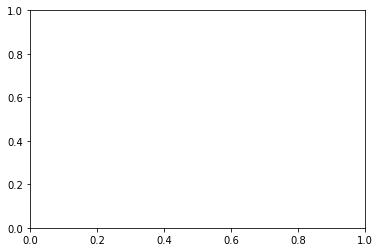

In [44]:
%matplotlib inline
from matplotlib import pyplot
from matplotlib.patches import Rectangle
ax = pyplot.gca()
# get coordinates
y1, x1, y2, x2 = boxes[0]
# calculate width and height of the box
width, height = x2 - x1, y2 - y1
# create the shape
rect = Rectangle((x1, y1), width, height, fill=False, color='red')
# draw the box
ax.add_patch(rect)

To keep things neat, we can create a function to do this that will take the filename of the photograph and the list of bounding boxes to draw and will show the photo with the boxes.

In [ ]:
# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()

We can now tie all of this together and load the pre-trained model and use it to detect objects in our photograph of an elephant, then draw the photograph with all detected objects.

The complete example is listed below.

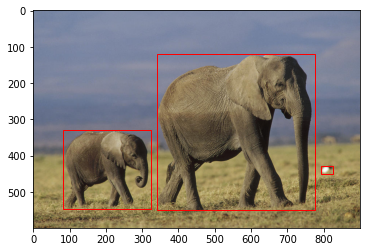

In [47]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()
 
# define the test configuration
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 80
 
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
# load coco model weights
rcnn.load_weights('/content/drive/My Drive/mask_rcnn_coco.h5', by_name=True)
# load photograph
img = load_img('/content/drive/My Drive/african-elephant.jpg')
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# visualize the results
draw_image_with_boxes('/content/drive/My Drive/african-elephant.jpg', results[0]['rois'])


Running the example loads the model and performs object detection. More accurately, we have performed object localization, only drawing bounding boxes around detected objects.

In this case, we can see that the model has correctly located the single object in the photo, the elephant, and drawn a red box around it.

## Example of Object Detection

Now that we know how to load the model and use it to make a prediction, let’s update the example to perform real object detection.

That is, in addition to localizing objects, we want to know what they are.

The `Mask_RCNN API` provides a function called `display_instances()` that will take the array of pixel values for the loaded image and the aspects of the prediction dictionary, such as the bounding boxes, scores, and class labels, and will plot the photo with all of these annotations.

One of the arguments is the list of predicted class identifiers available in the `class_id` key of the dictionary. The function also needs a mapping of ids to class labels. The pre-trained model was fit with a dataset that had 80 (81 including background) class labels, helpfully provided as a list in the [Mask R-CNN Demo, Notebook Tutorial](https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb), listed below.

In [ ]:
# define 81 classes that the coco model knowns about
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

We can then provide the details of the prediction for the elephant photo to the display_instances() function; for example:

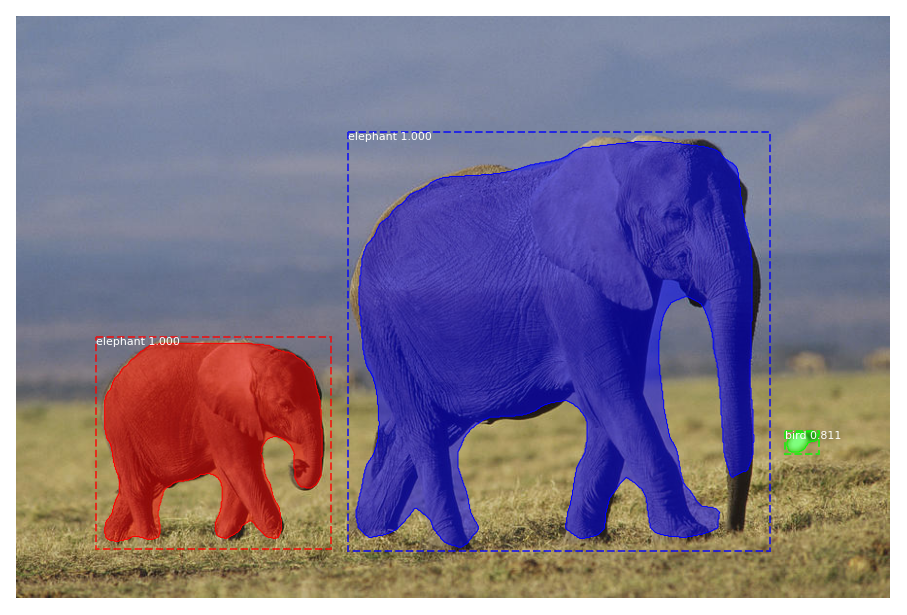

In [49]:
from mrcnn.visualize import display_instances
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

The `display_instances()` function is flexible, allowing you to only draw the mask or only the bounding boxes. You can learn more about this function in the `visualize.py` source file.

The complete example with this change using the `display_instances()` function is listed below.

Running the example shows the photograph of the two elephants with the annotations predicted by the Mask R-CNN model, specifically:

- __Bounding Box__: Dotted bounding box around each detected object.
- __Class Label__: Class label assigned each detected object written in the top left corner of the bounding box.
- __Prediction Confidence__: Confidence of class label prediction for each detected object written in the top left corner of the bounding box.
- __Object Mask Outline__: Polygon outline for the mask of each detected object.
- __Object Mask__: Polygon fill for the mask of each detected object.

The result is very impressive and sparks many ideas for how such a powerful pre-trained model could be used in practice.

## Suggestions for Your Project in DLV

1. Get familiar with different ConvNet architectures such as _EfficientNets_, _MobileNet_, etc. and apply transfer learning to your own dataset. Discuss the resulting confusion matrices and record test set accuracies, F1-scores, etc.

2. Get acquainted with the [Coconut Annotator](https://github.com/jsbroks/coco-annotator) or [labelImg](https://github.com/tzutalin/labelImg): download your own 
image dataset and annotate images. Use Transfer Learning for classification.

3. Discover which parts of an image are relevant for image classification. Apply GradCam and get familiar with [Layer-Wise Relevance Propagation](https://towardsdatascience.com/indepth-layer-wise-relevance-propagation-340f95deb1ea). Use LRP with Keras (https://pypi.org/project/keras-explain/) to your image classification task.

4. Use [YOLO](https://github.com/Ma-Dan/keras-yolo4) to detect objects in your dataset.

5. Get acquainted with the [Coconut Annotator](https://github.com/jsbroks/coco-annotator) or [labelImg](https://github.com/tzutalin/labelImg): download your own 
image dataset and segment objects in images. Use Mask R-CNN to detect and segment objects in validation dataset.

6. Compare speed and accuracy of object detection by Mask R-CNN and Yolo. Consider as well testing [SSD](https://github.com/pierluigiferrari/ssd_keras) 

# Mask detection

In [24]:
pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: c:\users\fabiantrottmann\anaconda3\envs\tensorflow\lib\site-packages\mask_rcnn-2.1-py3.7.egg
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


Download Images and Annotations from here: https://www.kaggle.com/andrewmvd/face-mask-detection

In [118]:
class Image:
    def __init__(self, absoluteFileName, width, height, depth, maskObjects):
        self.__maskObjects = maskObjects
        self.__absoluteFileName = absoluteFileName
        self.__size = [width, height, depth]
        
    def maskObjects(self):
        return self.__maskObjects
    def absoluteFilename(self):
        return self.__absoluteFileName
    def size(self):
        return self.__size
    def numberOfMasks(self):
        return len(self.__maskObjects)

class MaskObject:
    def __init__(self, label, xmin, ymin, xmax, ymax):
        self.__label = label
        self.__xmin = xmin
        self.__ymin = ymin
        self.__xmax = xmax
        self.__ymax = ymax
    def coords(self):
        return [self.__xmin, self.__ymin, self.__xmax, self.__ymax]
    def label(self):
        return self.__label

In [131]:
import xml.etree.ElementTree as ElementTree
import os.path

class MetadataExtractor:
    def __init__(self, basepath):
        self.__basepath = basepath
        
    def getImageMetadata(self, imageFileName):
        filenameWithoutExtension = os.path.splitext(imageFileName)[0]
        annotations = os.path.join(self.__basepath, 'annotations')
        images = os.path.join(self.__basepath, 'images')
        absolutPath = os.path.join(annotations, "{0}.{1}".format(filenameWithoutExtension, "xml"))
        tree = ElementTree.parse(absolutPath)
        root = tree.getroot()
        maskObjects = []
        for obj in root.findall('.//object'):
            label = obj.find('name').text
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            maskObject = MaskObject(label, xmin, ymin, xmax, ymax)
            maskObjects.append(maskObject)
        filename = root.find('filename').text
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        depth = int(size.find('depth').text)
        filename = root.find('filename').text
        absoluteFilename = os.path.join(images, filename)
        image = Image(absoluteFilename, width, height, depth, maskObjects)
        return image   

In [132]:
basepath = 'C:/Users/fabiantrottmann/Downloads/archive'
extractor = MetadataExtractor(basepath)
image = extractor.getImageMetadata('maksssksksss7.png')

print(image.absoluteFilename())
for mask in image.maskObjects():
    print(mask.label())
    print(mask.coords())

C:/Users/fabiantrottmann/Downloads/archive\images\maksssksksss7.png
with_mask
[253, 116, 342, 210]
with_mask
[152, 96, 222, 174]
with_mask
[120, 134, 173, 194]
without_mask
[118, 66, 135, 90]


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement ElementTree
ERROR: No matching distribution found for ElementTree
